In [31]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
DF = pd.read_csv('FERTILIZER_Merged.csv')

## Encoding the Categorical Variables
I have three methods for encoding the categorical variables. All will work off grouped data, taking the median values returned from each WEEK <br>
 - One method will "unmelt" a dataframe completely, making each YEAR and LOCATION its own instance. <br>
 - The 2nd method will hot-encode each categorical feature as its own column. However, this will not lead to each YEAR and LOCATION as being its own instance. This might be meaningful though, since information might be lost by the first method.
 - The 3rd method, which I think is necessary, is similar to above, but it will hot encode all categorical features. This will lead to no loss of information, and will create the same number of columns as method 1. This could be useful since Fertilizers, for example, aren't leading to individual responses, so we want to capture the fertilizer information for a given year.
    

In [33]:
# Not all rows contain soil information, but I still want to capture this. fill with dummy values.

DF_filled = DF.fillna(-999)

DF_grouped = DF_filled.groupby(['YEAR','LOCATION','FERTILIZER']).median()
DF_grouped = DF_grouped.reset_index().drop('WEEK_NUM',axis=1)
DF_grouped.loc[DF_grouped['FERTILIZER'] == -999, 'FERTILIZER'] = 'NONE'
DF_grouped.tail()

,YEAR,LOCATION,FERTILIZER,STATE_ANSI,APPLICATIONS_IN_LB_FERTILIZER,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FERTILIZER,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FERTILIZER,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER,AREA_OPERATED_IN_ACRES,...,CONDITION_5_YEAR_AVG_IN_PCT_GOOD,CONDITION_5_YEAR_AVG_IN_PCT_POOR,CONDITION_5_YEAR_AVG_IN_PCT_VERY_POOR,CONDITION_5_YEAR_AVG_IN_PCT_FAIR,CONDITION_PREVIOUS_YEAR_IN_PCT_POOR,CONDITION_PREVIOUS_YEAR_IN_PCT_GOOD,CONDITION_PREVIOUS_YEAR_IN_PCT_VERY_POOR,CONDITION_PREVIOUS_YEAR_IN_PCT_EXCELLENT,CONDITION_PREVIOUS_YEAR_IN_PCT_FAIR,YIELD_IN_BU_/_ACRE
1218,2019,OHIO,NONE,39,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,49.0,8.0,3.0,27.0,4.0,57.0,1.0,20.0,18.0,48.0
1219,2019,PENNSYLVANIA,NONE,42,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,55.0,3.0,0.0,18.0,2.0,56.0,0.0,18.0,24.0,48.0
1220,2019,SOUTH DAKOTA,NONE,46,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,51.0,7.0,3.0,25.0,8.0,49.0,6.0,14.0,24.0,43.0
1221,2019,TEXAS,NONE,48,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,35.0,9.0,2.0,42.0,12.0,18.0,5.0,9.0,58.0,31.0
1222,2019,WISCONSIN,NONE,55,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,50.0,5.0,1.0,16.0,6.0,47.0,2.0,29.0,16.0,46.0


In [34]:
def missing_data(dataframe) :
    for col in dataframe.columns :
        percent = sum(pd.isna(dataframe[col]))/dataframe.shape[0]
        print('Percent Misssing Data in Column {} : {}'.format(col,percent))

### Experiment with first method of hot-encoding a variable, this would lead to each YEAR/STATE combination having multiple rows in the dataframe, but at least information would not be lost.

In [6]:
def hot_encode_feature(dataframe,feature_to_encode) :
    
    df = dataframe.copy()
    unique_vals = df[feature_to_encode].unique()
    unique_vals = unique_vals[unique_vals != 'NONE']
    to_encode = {col:[] for col in unique_vals}
    
    for i,v in df.iterrows() :
        for k,val in to_encode.items() :
            if v[feature_to_encode] == k :
                to_encode[k].append(1)
            else :
                to_encode[k].append(0)
    
    pos = df.columns.get_loc(feature_to_encode) + 1
    for k,v in to_encode.items() :
        df.insert(pos, feature_to_encode+"_"+k , v)
        pos += 1
        
    return df.drop(feature_to_encode,axis=1)

In [7]:
DF_method1 = hot_encode_feature(DF_grouped,'FERTILIZER')

### Method 2 is written up below

In [8]:
def encode_new_features(dataframe,feature_to_encode) :
    
    df = dataframe.copy()
    unique_columns = [df.columns[2]] + list(df.columns[4:9])
    
    all_columns = []
    for c in df.columns:
        if c not in unique_columns:
            all_columns.append(c)
    for c in unique_columns:
        for i in range(len(set(df[df[feature_to_encode] != 'NONE'][feature_to_encode]))):
            all_columns.append(c+str(i))
            
    DF_freq = df.groupby(['YEAR', 'LOCATION']).size().reset_index(name='Freq')
    
    DF_out=np.zeros((df.groupby(['YEAR', 'LOCATION']).size().shape[0],len(all_columns)),dtype='object')

    row = 0
    new_row = 0
    while row <= df.shape[0] - DF_freq['Freq'].iloc[-1]:
        subbed_len = DF_freq['Freq'][new_row]
        count=0
        for c in all_columns:
            if c in df.columns:
                DF_out[new_row][count] = df[c][row]
                count+=1
        for c in unique_columns:
            for j in range(DF_freq['Freq'].max()):
                if j < subbed_len :
                    DF_out[new_row][count] = df[c][row+j]
                else :
                    DF_out[new_row][count] = np.nan
                count+=1  
        row = row + subbed_len
        new_row += 1
        
    DF_out = pd.DataFrame(DF_out,columns=all_columns)
    DF_out = DF_out.infer_objects()
    
    return DF_out

In [9]:
DF_method2 = encode_new_features(DF_grouped,'FERTILIZER')

### 3rd method is written up below

In [38]:
def hot_encode_mutliple_features(dataframe) :
    
    df = dataframe.copy()
    
    features_to_encode = [df.columns[2]] + list(df.columns[4:9])
    
    unique_vals = df[features_to_encode[0]].unique()
    unique_vals = unique_vals[unique_vals != 'NONE']
    to_encode = {col:[] for col in unique_vals}
    to_encode.update({col+"_"+uv:[] for col in features_to_encode[1:] for uv in unique_vals})

    to_encode_keys = list(to_encode.keys())
    
    DF_freq = df.groupby(['YEAR', 'LOCATION']).size().reset_index(name='Freq')
    for i,v in DF_freq.iterrows() :
        subbed = df[(df['YEAR'] == v['YEAR']) & (df['LOCATION'] == v['LOCATION'])]
        for k in unique_vals :
            ind_start = to_encode_keys.index(k)
            if k in subbed[features_to_encode[0]].values :
                ind_search = np.where(subbed[features_to_encode[0]] == k)[0][0]
                to_encode[k].append(1)
                for ind,key in enumerate(range(len(unique_vals),len(to_encode_keys),len(unique_vals))) :
                    to_encode[to_encode_keys[ind_start+key]].append(subbed[features_to_encode[ind+1]].values[ind_search])
            else :
                to_encode[k].append(0)
                for ind,key in enumerate(range(len(unique_vals),len(to_encode_keys),len(unique_vals))) :
                    to_encode[to_encode_keys[ind_start+key]].append(0)
    
    
    non_unique_cols = [col for col in df.columns if col not in features_to_encode]
    DF_new=np.zeros((DF_freq.shape[0],len(non_unique_cols)),dtype='object')

    row = 0
    new_row = 0
    while row <= DF_freq.shape[0] - DF_freq['Freq'].iloc[-1]:
        subbed_len = DF_freq['Freq'][new_row]
        count=0
        for c in non_unique_cols:
            DF_new[new_row][count] = df[c][row]
            count+=1
        row = row + subbed_len
        new_row += 1
        
    DF_new = pd.DataFrame(DF_new,columns=non_unique_cols) 
    DF_encoded = pd.DataFrame(to_encode)
    DF_encoded = DF_new.join(DF_encoded)
    
    DF_encoded = DF_encoded.infer_objects()
    
    return DF_encoded

In [39]:
DF_method3 = hot_encode_mutliple_features(DF_grouped)

## The two final datasets that we have the option to work with are listed below (with .head() command). Need to decide the best way to move forward. This will easily be built out to HERBICIDES, INSECTICIDES, FUNGICIDE as well (only experimented with fertilizer for now)

In [41]:
DF_method3.head()

,YEAR,LOCATION,Freq
0,1996,ALABAMA,1
1,1996,ARKANSAS,3
2,1996,DELAWARE,1
3,1996,FLORIDA,1
4,1996,GEORGIA,1


In [13]:
DF_method2.head()

,YEAR,LOCATION,STATE_ANSI,AREA_OPERATED_IN_ACRES,AREA_OPERATED_IN_ACRES_/_OPERATION,OPERATIONS_IN_OPERATIONS,AREA_HARVESTED_IN_ACRES,AREA_PLANTED_IN_ACRES,PRODUCTION_IN_BU,PRODUCTION_IN_$,...,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FERTILIZER2,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FERTILIZER3,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER0,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER1,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER2,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER3,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER0,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER1,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER2,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER3
0,1996,ALABAMA,1,9700000.0,198.0,49000.0,305000.0,320000.0,10370000.0,76738000.0,...,NaN,NaN,-999.0,NaN,NaN,NaN,-999.0,NaN,NaN,NaN
1,1996,ARKANSAS,5,14900000.0,301.0,49500.0,3600000.0,3650000.0,109800000.0,755424000.0,...,60.0,NaN,1.0,1.0,1.0,NaN,9.0,45.0,43.0,NaN
2,1996,DELAWARE,10,590000.0,211.0,2800.0,217000.0,220000.0,7595000.0,54684000.0,...,NaN,NaN,-999.0,NaN,NaN,NaN,-999.0,NaN,NaN,NaN
3,1996,FLORIDA,12,10700000.0,238.0,45000.0,45000.0,47000.0,1125000.0,7875000.0,...,NaN,NaN,-999.0,NaN,NaN,NaN,-999.0,NaN,NaN,NaN
4,1996,GEORGIA,13,11400000.0,233.0,49000.0,380000.0,400000.0,7980000.0,53306000.0,...,NaN,NaN,-999.0,NaN,NaN,NaN,-999.0,NaN,NaN,NaN


In [14]:
DF_method3.head()

,YEAR,LOCATION,STATE_ANSI,AREA_OPERATED_IN_ACRES,AREA_OPERATED_IN_ACRES_/_OPERATION,OPERATIONS_IN_OPERATIONS,AREA_HARVESTED_IN_ACRES,AREA_PLANTED_IN_ACRES,PRODUCTION_IN_BU,PRODUCTION_IN_$,...,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FERTILIZER_POTASH,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FERTILIZER_SULFUR,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER_NITROGEN,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER_PHOSPHATE,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER_POTASH,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER_SULFUR,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER_NITROGEN,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER_PHOSPHATE,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER_POTASH,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER_SULFUR
0,1996,ALABAMA,1,9700000.0,198.0,49000.0,305000.0,320000.0,10370000.0,76738000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1996,ARKANSAS,5,14900000.0,301.0,49500.0,3600000.0,3650000.0,109800000.0,755424000.0,...,60.0,0.0,1.0,1.0,1.0,0.0,9.0,45.0,43.0,0.0
2,1996,DELAWARE,10,590000.0,211.0,2800.0,217000.0,220000.0,7595000.0,54684000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1996,FLORIDA,12,10700000.0,238.0,45000.0,45000.0,47000.0,1125000.0,7875000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1996,GEORGIA,13,11400000.0,233.0,49000.0,380000.0,400000.0,7980000.0,53306000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
DF_method3.columns

Index(['YEAR', 'LOCATION', 'STATE_ANSI', 'AREA_OPERATED_IN_ACRES',
       'AREA_OPERATED_IN_ACRES_/_OPERATION', 'OPERATIONS_IN_OPERATIONS',
       'AREA_HARVESTED_IN_ACRES', 'AREA_PLANTED_IN_ACRES', 'PRODUCTION_IN_BU',
       'PRODUCTION_IN_$', 'PRICE_RECEIVED_IN_$_/_BU',
       'CONDITION_IN_PCT_VERY_POOR', 'CONDITION_IN_PCT_GOOD',
       'CONDITION_IN_PCT_FAIR', 'CONDITION_IN_PCT_POOR',
       'CONDITION_IN_PCT_EXCELLENT', 'CONDITION_5_YEAR_AVG_IN_PCT_EXCELLENT',
       'CONDITION_5_YEAR_AVG_IN_PCT_GOOD', 'CONDITION_5_YEAR_AVG_IN_PCT_POOR',
       'CONDITION_5_YEAR_AVG_IN_PCT_VERY_POOR',
       'CONDITION_5_YEAR_AVG_IN_PCT_FAIR',
       'CONDITION_PREVIOUS_YEAR_IN_PCT_POOR',
       'CONDITION_PREVIOUS_YEAR_IN_PCT_GOOD',
       'CONDITION_PREVIOUS_YEAR_IN_PCT_VERY_POOR',
       'CONDITION_PREVIOUS_YEAR_IN_PCT_EXCELLENT',
       'CONDITION_PREVIOUS_YEAR_IN_PCT_FAIR', 'YIELD_IN_BU_/_ACRE', 'NITROGEN',
       'PHOSPHATE', 'POTASH', 'SULFUR',
       'APPLICATIONS_IN_LB_FERTILIZER_NITROGEN

# Method 3 is the best, saving it to a csv to play with in modeling. 

In [26]:
DF_method3.to_csv('yield_condition_fertilizer_1130.csv',index=False)

## Just messed around with correlation

In [15]:
corr = DF_method3.corr()
pd.DataFrame(corr['YIELD_IN_BU_/_ACRE']).reset_index().sort_values('YIELD_IN_BU_/_ACRE')

,index,YIELD_IN_BU_/_ACRE
24,CONDITION_PREVIOUS_YEAR_IN_PCT_FAIR,-0.936552
23,CONDITION_PREVIOUS_YEAR_IN_PCT_EXCELLENT,-0.936552
22,CONDITION_PREVIOUS_YEAR_IN_PCT_VERY_POOR,-0.936552
21,CONDITION_PREVIOUS_YEAR_IN_PCT_GOOD,-0.936552
20,CONDITION_PREVIOUS_YEAR_IN_PCT_POOR,-0.936552
19,CONDITION_5_YEAR_AVG_IN_PCT_FAIR,-0.936552
18,CONDITION_5_YEAR_AVG_IN_PCT_VERY_POOR,-0.936552
16,CONDITION_5_YEAR_AVG_IN_PCT_GOOD,-0.936552
15,CONDITION_5_YEAR_AVG_IN_PCT_EXCELLENT,-0.936552
17,CONDITION_5_YEAR_AVG_IN_PCT_POOR,-0.936552


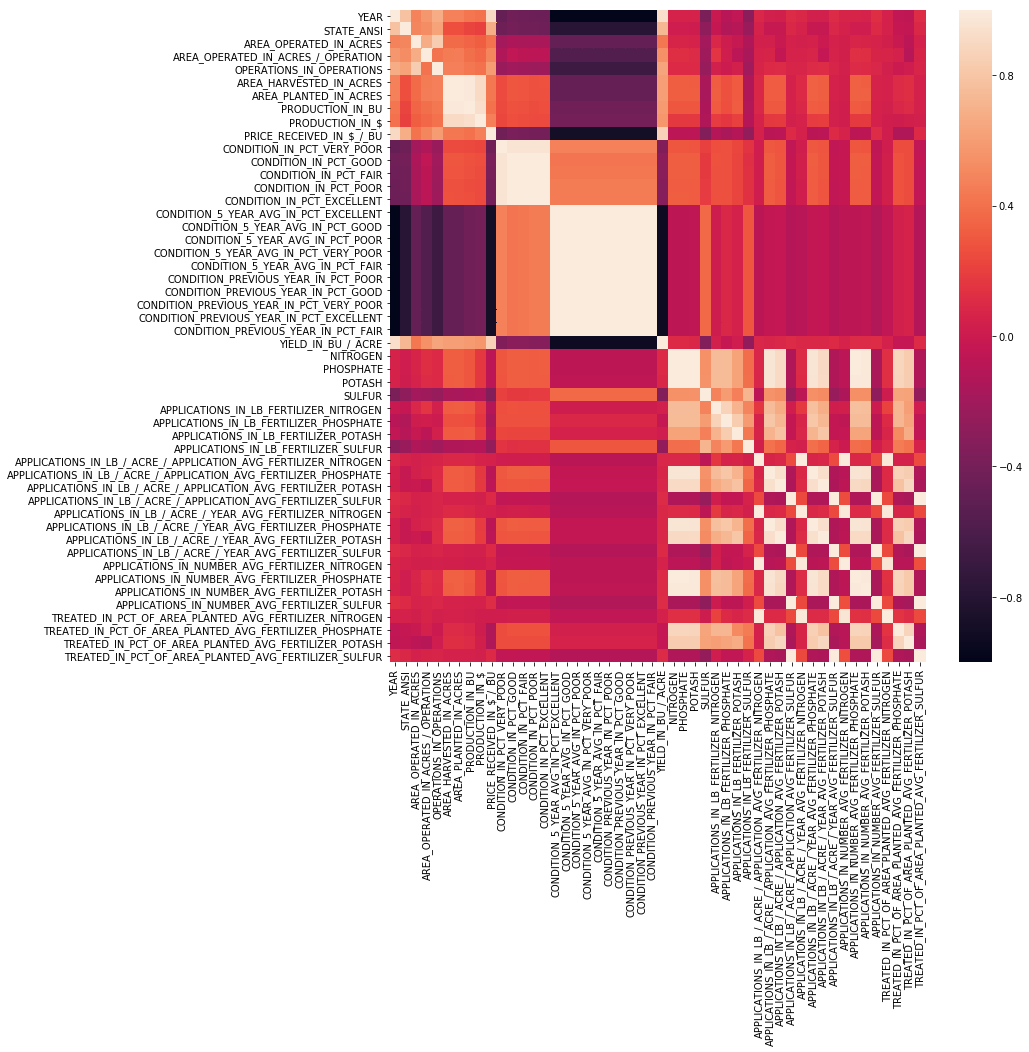

In [16]:
plt.figure(figsize=(12,12))
sns.heatmap(corr)
plt.show()

In [17]:
bushels_per_year = DF.groupby(['LOCATION','YEAR'])['YIELD_IN_BU_/_ACRE'].mean()
bushels_per_year = bushels_per_year.reset_index()

Messy, but each line represents the trend of YIELD for each state in the dataset


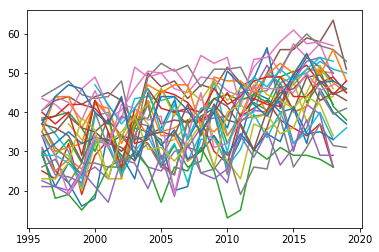

In [18]:
for state in bushels_per_year['LOCATION'].unique() :
    subbed_df = bushels_per_year[bushels_per_year['LOCATION'] == state]
    plt.plot(subbed_df['YEAR'],subbed_df['YIELD_IN_BU_/_ACRE'])
#plt.legend(labels = bushels_per_year['LOCATION'].unique(),loc='lower right')
print('Messy, but each line represents the trend of YIELD for each state in the dataset')
plt.show()